In [1]:
import fastai
from fastai.core import *
from fastai.basics import *
from fastai.basic_train import *
from fastai.text import *

import torch
import torch.nn as nn
import torch.utils.data as tdatautils

import pandas as pd
import numpy as np
from laservec import LASER
import html
import pickle
from unidecode import unidecode
import matplotlib.pyplot as plt


url = "localhost:8100"

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)

In [3]:
path.ls()

[PosixPath('/home/cris/.fastai/data/imdb_sample/models'),
 PosixPath('/home/cris/.fastai/data/imdb_sample/texts.csv')]

In [4]:
import pandas as pd

df = pd.read_csv(path/"texts.csv")
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df["label"].unique()

array(['negative', 'positive'], dtype=object)

In [6]:
class_index_lookup = {
    "negative": 0,
    "positive": 1
}

In [8]:
%%time

NUM_FEATURES = 1024
NUM_CLASSES = 2

def labels_to_categorical(labels:str, class_index_lookup:dict):    
    cat = np.zeros(NUM_CLASSES)
    for lbl in labels.split(","):
        class_index = class_index_lookup[lbl.strip()] 
        c = one_hot(class_index, NUM_CLASSES)
        cat = np.add(cat, c)  
        
    return cat

train_count = df[df["is_valid"] == False]["is_valid"].count()
valid_count = len(df) - train_count

X_train = np.zeros((train_count, NUM_FEATURES))
y_train = np.zeros((train_count, NUM_CLASSES))

X_valid = np.zeros((valid_count, NUM_FEATURES))
y_valid = np.zeros((valid_count, NUM_CLASSES))

train_index, valid_index = 0,0

with LASER(url) as laser:
    for i,row in enumerate(df.itertuples()):
        if i % 100 == 0:
            print(f"Processing row {i}")
            
        text = row.text
        label = row.label
        is_valid = row.is_valid
        embedding,_ = laser.vectorize(text)
        
        if not is_valid:
            X_train[train_index] = embedding
            y_train[train_index] = labels_to_categorical(label, class_index_lookup)
            train_index += 1
        else:
            X_valid[valid_index] = embedding
            y_valid[valid_index] = labels_to_categorical(label, class_index_lookup)    
            valid_index += 1
    

Processing row 0
Processing row 100
Processing row 200
Processing row 300
Processing row 400
Processing row 500
Processing row 600
Processing row 700
Processing row 800
Processing row 900
CPU times: user 1.73 s, sys: 148 ms, total: 1.87 s
Wall time: 35min 32s


In [9]:
X_train = torch.from_numpy(X_train).to(torch.float32)
y_train = torch.from_numpy(y_train).to(torch.float32)



NameError: name 'X_test' is not defined

In [10]:
X_valid = torch.from_numpy(X_valid).to(torch.float32)
y_valid = torch.from_numpy(y_valid).to(torch.float32)

In [13]:
train_ds = tdatautils.TensorDataset(X_train, y_train)
valid_ds = tdatautils.TensorDataset(X_valid, y_valid)

In [14]:
bs = 32
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [46]:
H1 = 512
H2 = 256
H3 = 128

model = nn.Sequential(
    nn.Linear(NUM_FEATURES, H1),
    nn.BatchNorm1d(H1),
    nn.ReLU(),
    nn.Linear(H1, H2),
    nn.BatchNorm1d(H2),
    nn.ReLU(),
    nn.Linear(H2, H3),
    nn.BatchNorm1d(H3),
    nn.ReLU(),
    nn.Linear(H3, NUM_CLASSES)
)

loss_func = nn.BCEWithLogitsLoss()

In [47]:
learner = Learner(data, model, opt_func=torch.optim.Adam, loss_func=loss_func, metrics=[accuracy_thresh])
learner

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f9a6cf246d0>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f99f4113d50>;

Test: None, model=Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=2, bias=True)
), opt_func=<class 'torch.optim.adam.Adam'>, loss_func=BCEWithLogitsLoss(), metrics=[<function accuracy_thresh at 0x7f99f694d950>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.par

In [48]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


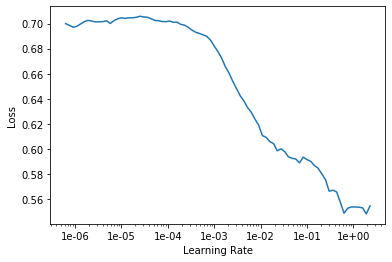

In [49]:
learner.recorder.plot()

In [50]:
lr = 1e-3
learner.fit_one_cycle(50, lr)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.692373,0.699178,0.500000,00:00
1,0.649471,0.690294,0.515000,00:00
2,0.593780,0.655487,0.612500,00:00
3,0.523040,0.606939,0.685000,00:00
4,0.434463,0.603941,0.630000,00:00
5,0.335752,0.557962,0.692500,00:00
6,0.246062,0.534309,0.725000,00:00
7,0.189473,0.700458,0.670000,00:00
8,0.148825,0.642057,0.702500,00:00
9,0.121310,1.183886,0.597500,00:00
